In [1]:
### The final code cell provides library version watermarks
import os
from os.path import join as opjoin
import numpy as np, pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt

from pingouin import ttest, rm_anova, pairwise_tests, linear_regression, corr
from scipy.stats import pearsonr

# Suppress some warnings
from warnings import filterwarnings
filterwarnings('ignore')

## Style and colors

In [15]:
# General plot style
sns.set_style('white')
sns.set_context('poster')

from matplotlib import rcParams
from matplotlib.lines import Line2D
# Set marker style
rcParams['markers.fillstyle'] = 'full'

# Set up color palette for experimental conditions
conditions = ['predictable','unpredictable','surprising']
colors = [np.array([64,176,166]),np.array([145,146,222]),np.array([225,190,106])]
colors_norm = [color/255 for color in colors]
colors_dict = {cnd:clrs for (cnd,clrs) in zip(conditions,colors_norm)}

# Sample description

In [39]:
df_sample = pd.read_csv("../data/sample.csv")

sample_data = df_sample['sex'].value_counts()
print(f"Sample size: {sample_data.sum()}, female: {sample_data['f']} ")

age_data = df_sample['age'].describe().round(1)
print(f"Mean age: {age_data['mean']} with SD {age_data['std']}")

Sample size: 41, female: 18 
Mean age: 27.0 with SD 3.9


# Training phase: Cover task

In [3]:
df_cover = pd.read_csv("../data/training_covertask.csv")

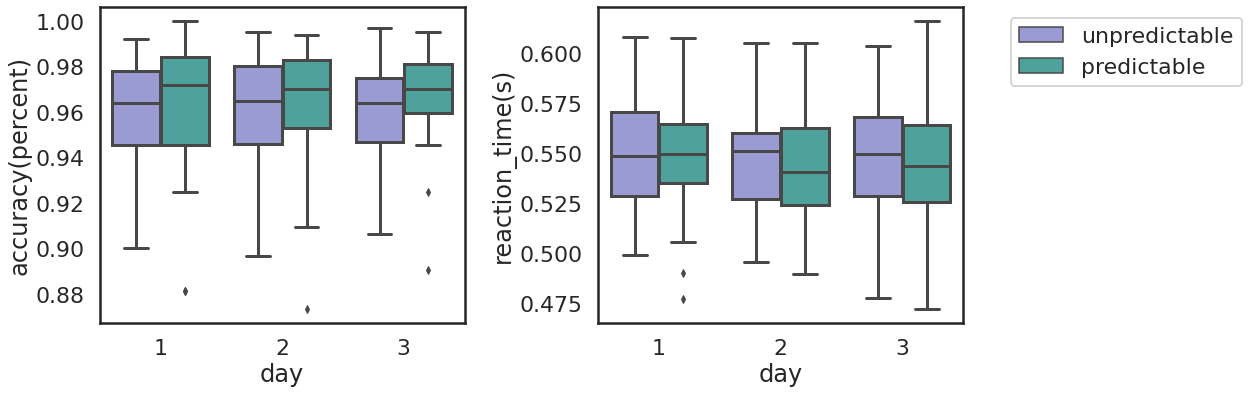

In [4]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(18,6))

sns.boxplot(data=df_cover, x='day', y='accuracy(percent)', hue='condition', palette=colors_dict, ax=axs[0])
sns.boxplot(data=df_cover, x='day', y='reaction_time(s)', hue='condition', palette=colors_dict, ax=axs[1])

axs[0].get_legend().remove()
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))

plt.tight_layout()

In [40]:
# Get an average over days for statistical analysis
df_cover_avg = df_cover.groupby(['subject','condition']).mean().drop(columns='day').reset_index()

print('Testing for differences in accuracy between conditions:')
display(ttest(df_cover_avg.query("condition == 'predictable'")['accuracy(percent)'].values,
                df_cover_avg.query("condition == 'unpredictable'")['accuracy(percent)'].values, paired=True))

print('Testing for differences in reaction time between conditions:')
display(ttest(df_cover_avg.query("condition == 'predictable'")['reaction_time(s)'].values,
                df_cover_avg.query("condition == 'unpredictable'")['reaction_time(s)'].values, paired=True))

Testing for differences in accuracy between conditions:


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.511592,40,two-sided,0.138499,"[-0.0, 0.01]",0.235741,0.481,0.313549


Testing for differences in reaction time between conditions:


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.399992,40,two-sided,0.169224,"[-0.01, 0.0]",0.113608,0.416,0.109468


# Training: Sequence completion task

In [5]:
# Get trial wise data and average
df_train = pd.read_csv('../data/training_sequenceTask.csv')
df_train_sub = df_train.groupby(['day','condition','subject']).mean().reset_index()

# Transform completion performance to percentage correct
df_train_sub['choice_correct'] = df_train_sub['choice_correct'] * 100

# Improvements in learning the sequences are reflected in confidence ratings
r, p = pearsonr(df_train_sub.query("(condition == 'predictable')")['confidence'].values,
        df_train_sub.query("(condition == 'predictable')")['choice_correct'].values)
print(f'Correlation between objective and subjective performance: r={np.round(r,3)}, p={p}')

Correlation between objective and subjective performance: r=0.755, p=6.65770909565123e-24


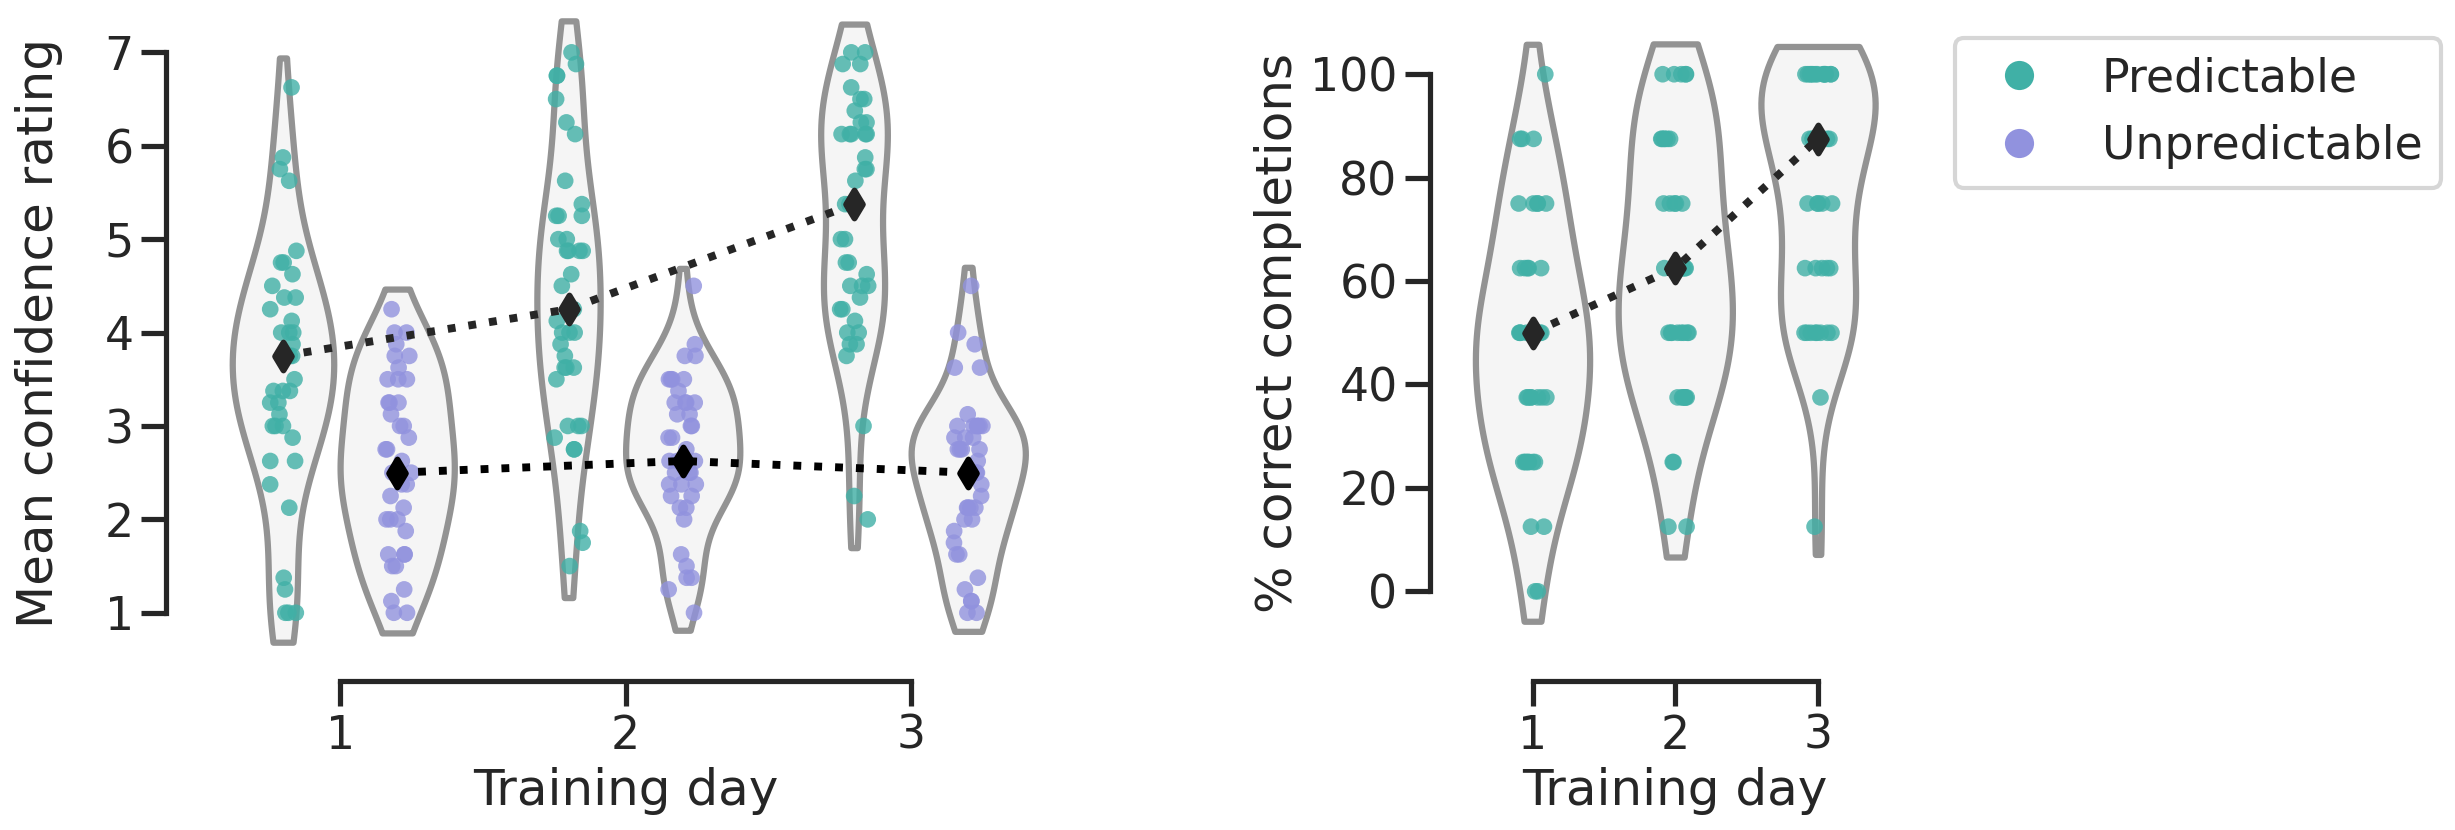

In [28]:
# Note that marker jitter is not deterministic and might look slightly different in the published article
fig, axs = plt.subplots(1,2, figsize=(19,8), sharex=True, gridspec_kw={'width_ratios':[2,1]}, dpi=150)

# Manual legend setup
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='#40B0A6', label='Predictable', markersize=15),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='#9192DE', label='Unpredictable', markersize=15)]

# Layer violin plots, strip plots and pointplots
violin1 = sns.violinplot(data=df_train_sub, x='day', y='confidence', hue='condition', inner=None,
               palette={'predictable':'whitesmoke','unpredictable':'whitesmoke'}, saturation=1, linewidth=3, cut=0.5,
               ax=axs.flatten()[0])

strip1 = sns.stripplot(data=df_train_sub, x='day', y='confidence', hue='condition', zorder=1,
              dodge=True, s=8, linewidth=0, palette=colors_dict, alpha=0.8,
               ax=axs.flatten()[0])

point1 = sns.pointplot(data=df_train_sub, x='day', y='confidence', hue='condition', estimator=np.median, zorder=2,
            dodge=0.4, markers='d', s=10, color='black', scale=0.7, linestyles=['dotted', 'dotted'], errwidth=0,
               ax=axs.flatten()[0])

violin2 = sns.violinplot(data=df_train_sub.query("condition == 'predictable'"), x='day', y='choice_correct', hue='condition', inner=None, #'quartile' for dashed median/quartiles
               palette={'predictable':'whitesmoke','unpredictable':'whitesmoke'}, saturation=1, linewidth=3, cut=0.5,
               ax=axs.flatten()[1])

strip2 = sns.stripplot(data=df_train_sub.query("condition == 'predictable'"), x='day', y='choice_correct', hue='condition', zorder=1,
              dodge=True, s=8, linewidth=0, palette=colors_dict, alpha=0.8,
               ax=axs.flatten()[1])

point2 = sns.pointplot(data=df_train_sub.query("condition == 'predictable'"), x='day', y='choice_correct', hue='condition', estimator=np.median, zorder=2,
            dodge=0.4, markers='d', s=10, color='black', scale=0.7, linestyles=['dotted', 'dotted'], errwidth=0,
               ax=axs.flatten()[1])

sns.despine(left=False, bottom=False, trim=True, offset=15)
plt.tick_params(axis='both', which='both', bottom=True, left=True)

axs.flatten()[0].tick_params(axis='both', which='both', bottom=True, left=True)
axs.flatten()[0].get_legend().remove()
axs.flatten()[0].set_xlabel('Training day')
axs.flatten()[0].set_ylabel('Mean confidence rating', labelpad=20)
axs.flatten()[0].set_ylim(0.6,7.4)

axs.flatten()[1].set_xlabel('Training day')
axs.flatten()[1].set_ylabel('% correct completions')
axs.flatten()[1].get_legend().remove()

# For the manuscript plot, a figure-wide legend is used instead of a subplot legend
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.1, 1))

plt.tight_layout(pad=4)
plt.show()

# Scanning day: Detection task  

In [17]:
df_detect = pd.read_csv('../data/training_detection_task.csv')
# Calculate percent change between detecting unpredictable vs. predictable objects
    # Negative values indicate quicker reactions
display(df_detect['RT_pctchange'].agg([np.median,np.std,np.max,np.min]))
ttest(x=df_detect['RT_pctchange'], y=0)

median   -10.752688
std       15.144677
amax      15.827338
amin     -47.747748
Name: RT_pctchange, dtype: float64

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.703655,40,two-sided,0.000001,"[-18.27, -8.71]",0.890761,1.395e+04,0.999842


In [30]:
# Merge with confidence ratings from predictable condition after last day
df_detect = df_detect.merge(df_train_sub.query("(day == 3) & (condition == 'predictable')")[['subject','confidence']], on='subject')

,n,r,CI95%,p-val,BF10,power
pearson,41,-0.53523,"[-0.72, -0.27]",0.000311,103.34,0.960874


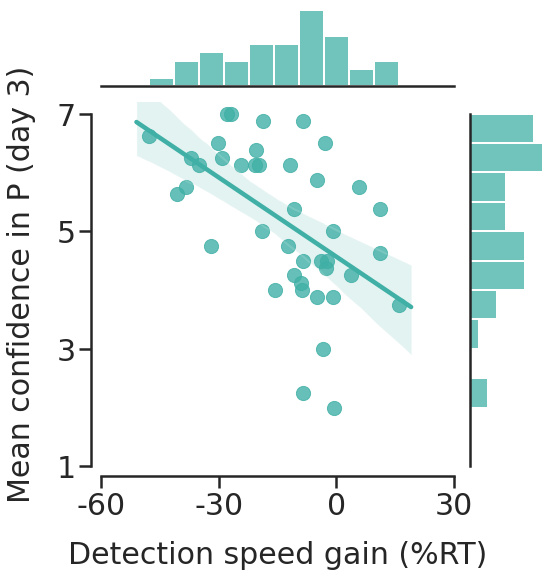

In [43]:
### Statistical association
display(corr(df_detect['confidence'], df_detect['RT_pctchange']))

fig = sns.jointplot(data=df_detect, y='confidence', x='RT_pctchange', kind='reg', truncate=False,
              height=8, ratio=4, color='#40B0A6',
              marginal_kws={'bins':10, 'kde':False, 'fill':True},
              scatter_kws={'s':200}
              )

fig.set_axis_labels(ylabel='Mean confidence in P (day 3)', xlabel='Detection speed gain (%RT)', labelpad=20, fontsize=30)
fig.ax_joint.set_ylim(1,7.2)
fig.ax_joint.set_xlim(-60,30)

xticks = range(-60, 31, 30)
fig.ax_joint.set_xticks(xticks)
fig.ax_joint.set_xticklabels(xticks)

yticks = range(1, 8, 2)
fig.ax_joint.set_yticks(yticks)
fig.ax_joint.set_yticklabels(yticks)
fig.ax_joint.tick_params(bottom=True, left=True, labelsize=30)

# Remove the intersection of x and y axis
fig.ax_joint.spines['left'].set_position(('outward', 10))
fig.ax_joint.spines['bottom'].set_position(('outward', 10))

sns.despine(ax=fig.ax_joint, trim=True)
sns.despine(ax=fig.ax_marg_x, left=True, bottom=False, trim=True)
sns.despine(ax=fig.ax_marg_y, left=False, bottom=True, right=True, trim=True)

# Imaging session: Cover task

In [7]:
df_scan_cover = pd.read_csv("../data/scanning_covertask.csv")
# Get descriptives per condition
stats = df_scan_cover.groupby('cond').agg([np.mean,np.median])

Text(0.5, 0, 'Catch trial RT (s)')

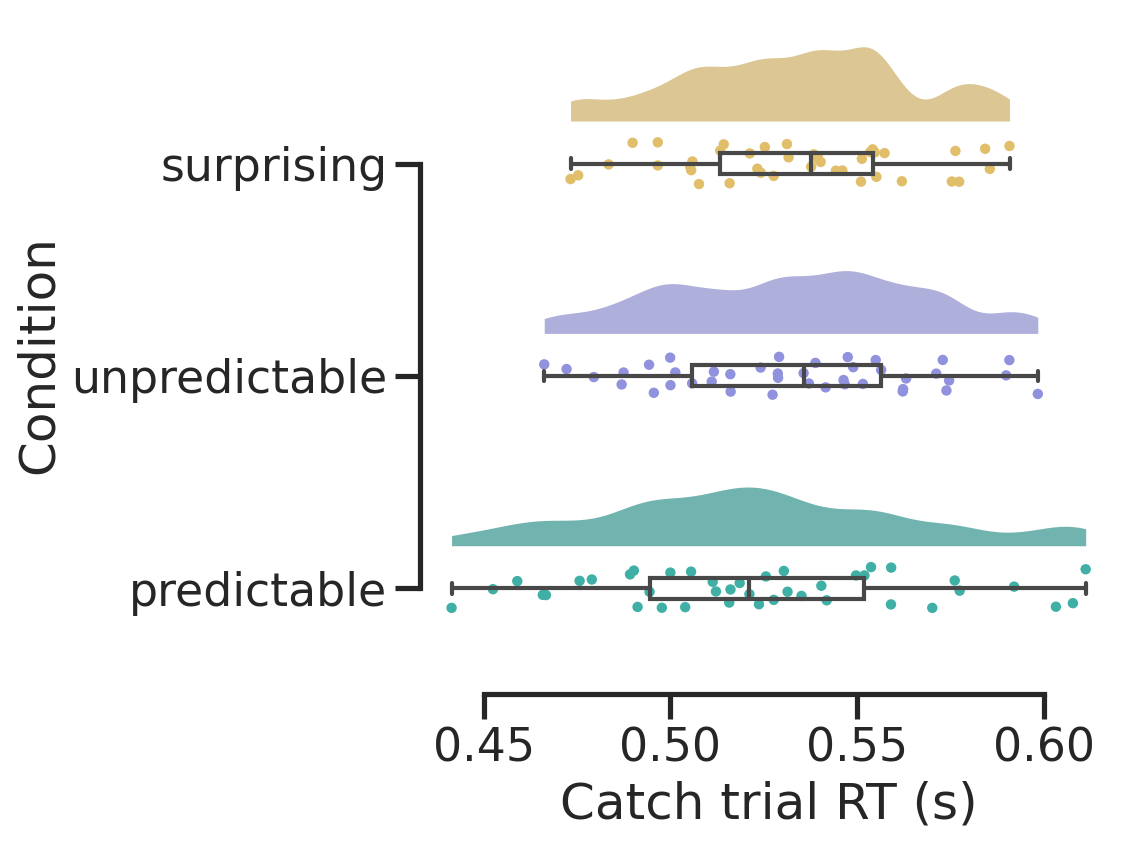

In [79]:
fig = plt.figure(figsize=(6,6), dpi=150)

pt.RainCloud(data=df_scan_cover, x='cond', y='RT', palette=colors_dict, orient='h', bw=0.2, alpha=0.8, point_size=5, linewidth=0., width_box=0.1, box_linewidth=2)
plt.tick_params(axis='both', which='both', bottom=True, left=True)
sns.despine(trim=True)

plt.ylabel('Condition')
plt.xlabel('Catch trial RT (s)')

In [ ]:
rm_anova(data=df_scan_cover, dv='RT', subject='subject', within='cond', detailed=True)

,Source,SS,DF,MS,F,p-unc,ng2,eps
0,cond,0.002485,2,0.001243,4.477714,0.014345,0.015704,0.953542
1,Error,0.022199,80,0.000277,NaN,NaN,NaN,NaN


In [17]:
pairwise_tests(data=df_scan_cover, dv='RT', within='cond', subject='subject', padjust='bonf')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,cond,predictable,surprising,True,True,-2.941570,40.0,two-sided,0.005408,0.016225,bonf,6.861,-0.265546
1,cond,predictable,unpredictable,True,True,-2.242133,40.0,two-sided,0.030565,0.091695,bonf,1.581,-0.233484
2,cond,surprising,unpredictable,True,True,0.236748,40.0,two-sided,0.814060,1.000000,bonf,0.173,0.026060


# Confidence - imaging cover task RT correlations

In [43]:
df_rtConf = pd.DataFrame({'Confidence (U)':df_train_sub.query("(condition == 'unpredictable') & (day == 3)")['confidence'].values,
                        'Confidence (P)':df_train_sub.query("(condition == 'predictable') & (day == 3)")['confidence'].values,
                        'RT (U)':df_scan_cover.query("cond == 'unpredictable'")['RT'].values,
                        'RT (P)':df_scan_cover.query("cond == 'predictable'")['RT'].values,
                        'RT (S)':df_scan_cover.query("cond == 'surprising'")['RT'].values})

(-0.4219425407433984, 0.0059994337643136985)

(0.20505881827576694, 0.19839786685266625)

(-0.3600117702757779, 0.020775583233017685)

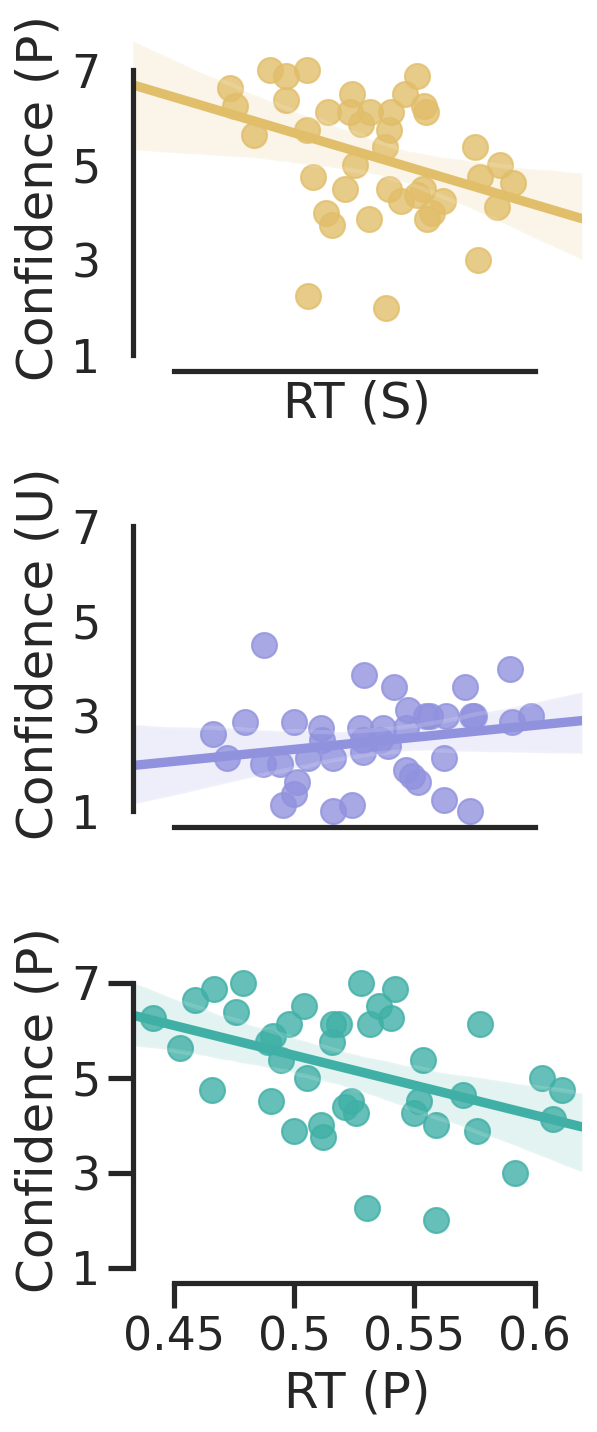

In [81]:
fig, axs = plt.subplots(3,1,figsize=(4.5,10), sharey=True, sharex=True, dpi=150)

sns.regplot(data=df_rtConf, x='RT (P)', y='Confidence (P)', color=colors_dict['predictable'],
            ax=axs.flatten()[2], truncate=False)
axs.flatten()[0].set_xlabel('')

sns.regplot(data=df_rtConf, x='RT (U)', y='Confidence (U)', color=colors_dict['unpredictable'],
            ax=axs.flatten()[1], truncate=False)
axs.flatten()[1].set_xlabel('')

sns.regplot(data=df_rtConf, x='RT (S)', y='Confidence (P)', color=colors_dict['surprising'], # using confidence ratings from predictable sequences, which form the basis for surprising sequences
            ax=axs.flatten()[0], truncate=False)

yticks = range(1, 8, 2)
for ax in axs:
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)

xticks = np.linspace(0.45, 0.60, 4)
for ax in axs:
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)

plt.tick_params(axis='both', which='both', bottom=True, left=True)
sns.despine(trim=True)   

plt.tight_layout()

display(pearsonr(df_rtConf['RT (P)'], df_rtConf['Confidence (P)']))
display(pearsonr(df_rtConf['RT (U)'].values, df_rtConf['Confidence (U)']))
display(pearsonr(df_rtConf['RT (S)'].values, df_rtConf['Confidence (P)']))

In [26]:
# Library versions
!python -V
!pip show numpy pandas matplotlib seaborn scipy pingouin | grep -e Name -e Version

Python 3.8.12
Name: numpy
Version: 1.22.3
Name: pandas
Version: 1.4.1
Name: matplotlib
Version: 3.5.1
Name: seaborn
Version: 0.11.1
Name: scipy
Version: 1.7.3
Name: pingouin
Version: 0.5.2
